https://tutorials.pytorch.kr/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

### 데이터는 어떻게 하나요?

일반적으로 이미지나 텍스트, 오디오나 비디오 데이터를 다룰 때는 표준 Python 패키지를 이용하여 Numpy 배열로 불러오면 됩니다. 그 후 배열을 `torch.*Tensor`로 변환합니다.
* 이미지는 Pillow나 OpenCV 같은 패키지가 유용합니다.
* 오디오를 처리할 때는 SciPy와 LibROSA가 유용하고요.
* 텍스트의 경우에는 그냥 Python이나 Cython을 사용해도 되고, NLTK나 SpaCy도 유용합니다.

특별히 영상 분야를 위한 `torchvision`이라는 패키지가 만들어져 있는데, 여기에는 Imagenet이나 CIFAR10, MNIST 등과 같이 일반적으로 사용하는 데이터셋을 위한 데이터 로더(data loader), 즉 `torchvision.datasets`과 이미지용 데이터 변환기(data transformer), 즉 `torch.utils.data.DataLoader`가 포함되어 있습니다.<br>
이러한 기능은 엄청나게 편리하며, 매번 유사한 코드(boilerplate code)를 반복해서 작성하는 것을 피할 수 있습니다.

# 이미지 분류기 학습하기

1. `torchvision`을 사용하여 CIFAR10의 학습용/시험용 데이터셋을 불러오고, 정규화(normalizing)합니다.
2. 합성곱 신경망(Convolution Neural Network)을 정의합니다.
3. 손실 함수를 정의합니다.
4. 학습용 데이터를 사용하여 신경망을 학습합니다.
5. 시험용 데이터를 사용하여 신경망을 검사합니다.

# 1. CIFAR10를 불러오고 정규화하기

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True,
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True,num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


---
### Understaning transform.Normalize(mean, std, inplace=Flase)
---

https://discuss.pytorch.org/t/understanding-transform-normalize/21730

Normalize dose the following for each channel:<br>
`image = (image - mean) / std`<br>
The parameters `mean, std` are passed as 0.5, 0.5 in our case. This will normalize the image in the range \[-1,1\]. For example, the minimum value 0 will be converted to `(0-0.5)/0.5 = -1`, the maximum value of 1 will be converted to `(1-0.5)/0.5=1.`<br>
If you would like to get your image back in \[0,1\] range, you could use,<br>
`image = ((image * std) + mean)`<br>
About whether it helps CNN to learn better, I'm not sure. But majority of the papers I read employ some normalization schema. What you are following is one of them.


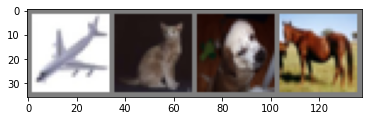

plane    cat    dog  horse


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img/2 + 0.5   # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print('  '.join('%5s'%classes[labels[j]] for j in range(4)))

# 2. 합성곱 신경망(Convolution Neural Network) 정의하기

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # CIFAR10: (B, 3, 32, 32)
        x = self.pool(F.relu(self.conv1(x)))
        # (B, 6, 28, 28)
        # (B, 6, 14, 14)
        x = self.pool(F.relu(self.conv2(x)))
        # (B, 16, 10, 10)
        # (B, 16, 5, 5)
        x = x.view(-1, 16*5*5)
        # (B, 16*5*5)
        x = F.relu(self.fc1(x))
        # (B, 120)
        x = F.relu(self.fc2(x))
        # (B, 84)
        x = self.fc3(x)
        # (B, 10)
        return x

net = Net()

# 3. 손실 함수와 Optimizer 정의하기

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 4. 신경망 학습하기

In [ ]:
for epoch in range(2):  # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, label]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 ==1999:     # print every 2000 mini-batches
            print('[%d %5d] loss: %.3f'%
                  (epoch + 1, i + 1, running_loss/2000))
            running_loss = 0.0

print('Finished Training')

[1  2000] loss: 2.234
[1  4000] loss: 1.902
[1  6000] loss: 1.688
[1  8000] loss: 1.567
[1 10000] loss: 1.542
[1 12000] loss: 1.444
[2  2000] loss: 1.400
[2  4000] loss: 1.362
[2  6000] loss: 1.329
[2  8000] loss: 1.309
[2 10000] loss: 1.290
[2 12000] loss: 1.294
Finished Training


In [ ]:
# 학습된 모델 저장

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

# 5. 시험용 데이터로 신경망 검사하기

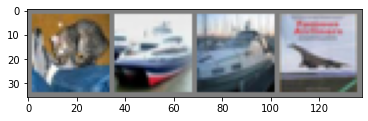

GroundTruth:    cat  ship  ship plane


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ',' '.join('%5s'%classes[labels[j]] for j in range(4)))

In [ ]:
# 저장했던 모델 불러오기

net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print("Predicted: ", ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car   car  ship


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test iamges: %d %%'%(
    100 * correct / total
))

Accuracy of the network on the 10000 test iamges: 56 %


In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' %(
        classes[i], 100*class_correct[i]/class_total[i]
    ))

Accuracy of plane : 57 %
Accuracy of   car : 79 %
Accuracy of  bird : 28 %
Accuracy of   cat : 37 %
Accuracy of  deer : 49 %
Accuracy of   dog : 40 %
Accuracy of  frog : 72 %
Accuracy of horse : 68 %
Accuracy of  ship : 64 %
Accuracy of truck : 62 %


# GPU에서 학습하기

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# CUDA 기기가 존재한다면, 아래 코드가 CUDA 장치를 출력합니다:

print(device)

cuda:0


In [ ]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
inputs, labels = data[0].to(device), data[1].to(device)